# End product of this part of the project; tables comparing NB effectiveness in recovering stellar parameters to ugrizy.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pylab as plt
from scipy.stats import binned_statistic
from sklearn.neighbors import KDTree
import matplotlib as mpl

In [2]:
plt.style.use('default')
plt.style.use('ggplot')

In [3]:
# our stellar models:

with np.load('model_atm_mags.npz') as nump_zip:
    model_atm_mags = nump_zip['model_atm_mags']

In [4]:
# our "data":

temp = np.load('truth_catalog.npz')
truth_catalog = temp['truth_catalog'].copy()
temp.close()

## Broadband Tree:

In [5]:
model_color1 = model_atm_mags['u'] - model_atm_mags['g']
model_color2 = model_atm_mags['g'] - model_atm_mags['r']
model_color3 = model_atm_mags['r'] - model_atm_mags['i']
model_color4 = model_atm_mags['i'] - model_atm_mags['z']
model_color5 = model_atm_mags['z'] - model_atm_mags['y']

mag_model = np.array([model_color1, model_color2, model_color3, model_color4, model_color5]).T

In [6]:
broadleafed_tree = KDTree(mag_model)

True Colors:

In [7]:
bcolor1 = truth_catalog['u'] - truth_catalog['g']
bcolor2 = truth_catalog['g'] - truth_catalog['r']
bcolor3 = truth_catalog['r'] - truth_catalog['i']
bcolor4 = truth_catalog['i'] - truth_catalog['z']
bcolor5 = truth_catalog['z'] - truth_catalog['y']

sim_colors = np.array([bcolor1, bcolor2, bcolor3, bcolor4, bcolor5]).T
dist_bcolors, indx_match_bcolors = broadleafed_tree.query(sim_colors, k=1)

## Narrowband Tree:

In [8]:
model_ncolor0 = model_atm_mags['F861'] - model_atm_mags['z']
model_ncolor1 = model_atm_mags['r'] - model_atm_mags['F660']
model_ncolor2 = model_atm_mags['g'] - model_atm_mags['F515']
model_ncolor3 = model_atm_mags['F430'] - model_atm_mags['g']
model_ncolor4 = model_atm_mags['F410'] - model_atm_mags['g']
model_ncolor5 = model_atm_mags['u'] - model_atm_mags['F395']
model_ncolor6 = model_atm_mags['u'] - model_atm_mags['F378']

ncolormodel = np.array(
    [model_ncolor0, model_ncolor1, model_ncolor2, model_ncolor3, model_ncolor4, model_ncolor5, model_ncolor6]
).T

In [9]:
narrowleafed_tree = KDTree(ncolormodel)

True Colors:

In [10]:
nbcolor0 = truth_catalog['F861'] - truth_catalog['z']
nbcolor1 = truth_catalog['r'] - truth_catalog['F660']
nbcolor2 = truth_catalog['g'] - truth_catalog['F515']
nbcolor3 = truth_catalog['F430'] - truth_catalog['g']
nbcolor4 = truth_catalog['F410'] - truth_catalog['g']
nbcolor5 = truth_catalog['u'] - truth_catalog['F395']
nbcolor6 = truth_catalog['u'] - truth_catalog['F378']

nbsim_colors = np.array([nbcolor0, nbcolor1, nbcolor2, nbcolor3, nbcolor4, nbcolor5, nbcolor6]).T
dist_nbcolors, indx_match_nbcolors = narrowleafed_tree.query(nbsim_colors, k=1)

## Bring the Noise:

In [11]:
def mag_error(m, snr):
    # https://www.eso.org/~ohainaut/ccd/sn.html
    dmag = 2.5*np.log10(1.+1./snr)
    return dmag

In [12]:
def alternateSNR(C_m, m_sky, magnitude, N):
    """
    Gives a SNR for a star based on N LSST observations & C_M plus m_sky in a particular filter.
    """
    m5 = C_m + 0.5*(m_sky-21)
    snr = 5.*10.**(-0.4*(magnitude-m5))
    snr = np.sqrt(N) * snr
    return(snr)

Sky brightness:

In [13]:
# Wavelengths: 378, 395, 410, 430, 515, 660, 861 nm

nb_skymags = [22.63060826, 22.66559093, 22.39495818, 22.37808949, 21.89181356, 21.22310616, 19.36278739]

In [14]:
# u g r i z y

bb_skymags = [22.72624638, 22.0279839, 21.08485684, 20.25334748, 18.15891063, 19.33414126]

That constant thing that you have to add but I don't know what it actually is:

In [15]:
C_m = [23.09, 24.42, 24.44, 24.32, 24.16, 23.73]

# just the C_m number for whatever the nearest broadband filter is:
# NOTE THIS IS ONE OF THE THINGS WE SHOULD GO BACK AND CHECK!

C_m_nb = [23.09, 23.09, 24.42, 24.42, 24.42, 24.44, 24.16]

Number of exposures for broad and narrow bands at 1 & 10 years:

In [16]:
# number of total survey exposures in each (broadband) filter:

expnos1yr = [14623, 16330, 39324, 30745, 68542, 57904]

expnos = [177538, 234144, 515172, 514481, 486208, 445157]

In [17]:
# number of total exposures for a particular star in each filter:

star_exp_per_filt = 825*np.array([filt/np.sum(expnos) for filt in expnos])

star_exp_per_filt_1yr = 83*np.array([filt/np.sum(expnos1yr) for filt in expnos1yr])

# for narrow bands (just making these up):
# Maybe redo these? idk I did actually try tweaking them quite a bit when I was first writing this notebook
# and it didn't really seem to have all that mcuh effect... so maybe not worth bothering with?

nb_N_1yr = [3, 3, 6, 9, 9, 8, 6]
nb_N = [30, 30, 90, 90, 90, 80, 70]

In [18]:
mag_names = ['u', 'g', 'r', 'i', 'z', 'y']

NB_names = ['F378', 'F395', 'F410', 'F430', 'F515', 'F660', 'F861']

## Getting Observed Mags:

Broad band, 10 years:

In [19]:
# Set the random number seed to make things repeatable.

np.random.seed(42)

# Let's make some as-observed mags.

bbmagerr = []

bb_observations = np.zeros(truth_catalog.size, dtype=list(zip(mag_names, [float]*len(mag_names))))

for ii in range(len(bb_skymags)):
    
    # SNR for a filter:
    
    snrs = alternateSNR(C_m[ii], bb_skymags[ii], truth_catalog[mag_names[ii]], star_exp_per_filt[ii])
    
    # Magnitude errors for each star
    
    mag_errors_realize = mag_error(truth_catalog[mag_names[ii]], snrs)
    
    bbmagerr.append([mag_errors_realize])
    
    # 'Observed' mags for each star (original mag + error)
    
    bb_observations[mag_names[ii]] = truth_catalog[mag_names[ii]] + np.random.randn(truth_catalog[mag_names[ii]].size)*mag_errors_realize

10 Year Narrow Bands:

In [20]:
# Let's make some as-observed mags.

nbmagerr = []

nb_observations = np.zeros(truth_catalog.size, dtype=list(zip(NB_names, [float]*len(NB_names))))

for ii in range(len(nb_skymags)):
    
    # SNR for a filter:
    
    snrs = alternateSNR(C_m_nb[ii], nb_skymags[ii], truth_catalog[NB_names[ii]], nb_N[ii])
    
    # Magnitude errors for each star
    
    mag_errors_realize = mag_error(truth_catalog[NB_names[ii]], snrs)
    
    nbmagerr.append([mag_errors_realize])
    
    # 'Observed' mags for each star (original mag + error)
    
    nb_observations[NB_names[ii]] = truth_catalog[NB_names[ii]] + np.random.randn(truth_catalog[NB_names[ii]].size)*mag_errors_realize

BB 1 year:

In [21]:
np.random.seed(42)

# Let's make some as-observed mags.

bbmagerr1yr = []

bb_observations1yr = np.zeros(truth_catalog.size, dtype=list(zip(mag_names, [float]*len(mag_names))))

for ii in range(len(bb_skymags)):
    
    # SNR for a filter:
    
    snrs = alternateSNR(C_m[ii], bb_skymags[ii], truth_catalog[mag_names[ii]], star_exp_per_filt_1yr[ii])
    
    # Magnitude errors for each star
    
    mag_errors_realize = mag_error(truth_catalog[mag_names[ii]], snrs)
    
    bbmagerr1yr.append([mag_errors_realize])
    
    # 'Observed' mags for each star (original mag + error)
    
    bb_observations1yr[mag_names[ii]] = truth_catalog[mag_names[ii]] + np.random.randn(truth_catalog[mag_names[ii]].size)*mag_errors_realize

NB 1 year:

In [22]:
nbmagerr1yr = []

nb_observations1yr = np.zeros(truth_catalog.size, dtype=list(zip(NB_names, [float]*len(NB_names))))

for ii in range(len(nb_skymags)):
    
    # SNR for a filter:
    
    snrs = alternateSNR(C_m_nb[ii], nb_skymags[ii], truth_catalog[NB_names[ii]], nb_N_1yr[ii])
    
    # Magnitude errors for each star
    
    mag_errors_realize = mag_error(truth_catalog[NB_names[ii]], snrs)
    
    nbmagerr1yr.append([mag_errors_realize])
    
    # 'Observed' mags for each star (original mag + error)
    
    nb_observations1yr[NB_names[ii]] = truth_catalog[NB_names[ii]] + np.random.randn(truth_catalog[NB_names[ii]].size)*mag_errors_realize

Getting our indices:

In [23]:
early_obscolor1 = nb_observations1yr['F861'] - bb_observations1yr['z']
early_obscolor2 = bb_observations1yr['r'] - nb_observations1yr['F660']
early_obscolor3 = bb_observations1yr['g'] - nb_observations1yr['F515']
early_obscolor4 = nb_observations1yr['F430'] - bb_observations1yr['g']
early_obscolor5 = nb_observations1yr['F410'] - bb_observations1yr['g']
early_obscolor6 = bb_observations1yr['u'] - nb_observations1yr['F395']
early_obscolor7 = bb_observations1yr['u'] - nb_observations1yr['F378']

obs_colors = np.array([early_obscolor1, early_obscolor2, early_obscolor3, early_obscolor4, early_obscolor5, early_obscolor6, early_obscolor7]).T
dist_early_nb_obscolors, indx_match_early_nb_obscolors = narrowleafed_tree.query(obs_colors, k=1)

indx_match_early_nb_obscolors = indx_match_early_nb_obscolors[:,0]

In [24]:
obscolor1 = nb_observations['F861'] - bb_observations['z']
obscolor2 = bb_observations['r'] - nb_observations['F660']
obscolor3 = bb_observations['g'] - nb_observations['F515']
obscolor4 = nb_observations['F430'] - bb_observations['g']
obscolor5 = nb_observations['F410'] - bb_observations['g']
obscolor6 = bb_observations['u'] - nb_observations['F395']
obscolor7 = bb_observations['u'] - nb_observations['F378']

obs_colors = np.array([obscolor1, obscolor2, obscolor3, obscolor4, obscolor5, obscolor6, obscolor7]).T
dist_nb_obscolors, indx_match_nb_obscolors = narrowleafed_tree.query(obs_colors, k=1)

indx_match_nb_obscolors = indx_match_nb_obscolors[:,0]

In [25]:
early_obscolor1 = bb_observations1yr['u'] - bb_observations1yr['g'] # u-g
early_obscolor2 = bb_observations1yr['g'] - bb_observations1yr['r'] # g-r
early_obscolor3 = bb_observations1yr['r'] - bb_observations1yr['i'] # r-i
early_obscolor4 = bb_observations1yr['i'] - bb_observations1yr['z'] # i-z
early_obscolor5 = bb_observations1yr['z'] - bb_observations1yr['y'] # z-y

early_obscolors = np.array([early_obscolor1, early_obscolor2, early_obscolor3, early_obscolor4, early_obscolor5]).T
dist_early_obscolors, indx_match_early_obscolors = broadleafed_tree.query(early_obscolors, k=1)

indx_match_early_obscolors = indx_match_early_obscolors[:,0]

In [26]:
obscolor1 = bb_observations['u'] - bb_observations['g'] # u-g
obscolor2 = bb_observations['g'] - bb_observations['r'] # g-r
obscolor3 = bb_observations['r'] - bb_observations['i'] # r-i
obscolor4 = bb_observations['i'] - bb_observations['z'] # i-z
obscolor5 = bb_observations['z'] - bb_observations['y'] # z-y

obs_colors = np.array([obscolor1, obscolor2, obscolor3, obscolor4, obscolor5]).T
dist_obscolors, indx_match_obscolors = broadleafed_tree.query(obs_colors, k=1)

indx_match_obscolors = indx_match_obscolors[:,0]

Narrow band tree residuals:

In [27]:
# 10 years:

nb_teff_diff = np.array(truth_catalog['Teff']-model_atm_mags['Teff'][indx_match_nb_obscolors])
nb_Z_diff = np.array(truth_catalog['log_Z']-model_atm_mags['log_Z'][indx_match_nb_obscolors])
nb_G_diff = np.array(truth_catalog['gravity']-model_atm_mags['gravity'][indx_match_nb_obscolors])

# 1 year:

early_nb_teff_diff = np.array(truth_catalog['Teff']-model_atm_mags['Teff'][indx_match_early_nb_obscolors])
early_nb_Z_diff = np.array(truth_catalog['log_Z']-model_atm_mags['log_Z'][indx_match_early_nb_obscolors])
early_nb_G_diff = np.array(truth_catalog['gravity']-model_atm_mags['gravity'][indx_match_early_nb_obscolors])

Broad band tree residuals:

In [28]:
# 10 years:

teff_diff = np.array(truth_catalog['Teff']-model_atm_mags['Teff'][indx_match_obscolors])
Z_diff = np.array(truth_catalog['log_Z']-model_atm_mags['log_Z'][indx_match_obscolors])
G_diff = np.array(truth_catalog['gravity']-model_atm_mags['gravity'][indx_match_obscolors])

# 1 year:

early_teff_diff = np.array(truth_catalog['Teff']-model_atm_mags['Teff'][indx_match_early_obscolors])
early_Z_diff = np.array(truth_catalog['log_Z']-model_atm_mags['log_Z'][indx_match_early_obscolors])
early_G_diff = np.array(truth_catalog['gravity']-model_atm_mags['gravity'][indx_match_early_obscolors])

## Uncomment next two cells for r magnitude histograms of real and observed mags. But I'm guessing they aren't really necessary at this point.

## Binning and Finding Standard Deviations of Residuals:

In [29]:
def binnedFitParams(true_mags, true_param, model_param, fit_indices, bin_len):
    
    """
    Bins a stellar parameter according to a list of magnitiudes. Also needs the indices from whichever KD-tree
    is being used. Also the length of each bin. Outputs binned magnitudes, standard deviation of each model_parameter
    bin, and average value of the parameter in each bin. That's as close to proper docstrings as this is going
    to get.
    """
    
    bins = np.arange(np.min(true_mags), np.max(true_mags), bin_len)

    digitize = np.digitize(true_mags, bins)

    bin_std = [
        np.std((true_param - model_param[fit_indices])[digitize == i]) for i in range(len(bins))
    ]

    # editing so it's the residuals rather than the model_parameter itself:
    
    bin_means = [
        (true_param - model_param[fit_indices])[digitize == i].mean() for i in range(len(bins))
    ]

    param_std = np.array(bin_std)[np.where(np.isnan(bin_means) == False)]

    mag_bins = np.array(bins)[np.where(np.isnan(bin_means) == False)]

    param_bin_means = np.array(bin_means)[np.where(np.isnan(bin_means) == False)]
    
    return(mag_bins, param_std, param_bin_means)

# The Main Event:

Let's look at Teff first:

In [30]:
# Broadband colors:

u1yr_teff = binnedFitParams(truth_catalog['u'], truth_catalog['Teff'], model_atm_mags['Teff'], indx_match_early_obscolors, 1.0)

std_u1yr_teff = u1yr_teff[1]
mag_u1yr_teff = u1yr_teff[0]
temp_u1yr_teff = u1yr_teff[2]

u10yr_teff = binnedFitParams(truth_catalog['u'], truth_catalog['Teff'], model_atm_mags['Teff'], indx_match_obscolors, 1.0)

std_u10yr_teff = u10yr_teff[1]
mag_u10yr_teff = u10yr_teff[0]
temp_u10yr_teff = u10yr_teff[2]



g1yr_teff = binnedFitParams(truth_catalog['g'], truth_catalog['Teff'], model_atm_mags['Teff'], indx_match_early_obscolors, 1.0)

std_g1yr_teff = g1yr_teff[1]
mag_g1yr_teff = g1yr_teff[0]
temp_g1yr_teff = g1yr_teff[2]

g10yr_teff = binnedFitParams(truth_catalog['g'], truth_catalog['Teff'], model_atm_mags['Teff'], indx_match_obscolors, 1.0)

std_g10yr_teff = g10yr_teff[1]
mag_g10yr_teff = g10yr_teff[0]
temp_g10yr_teff = g10yr_teff[2]



r1yr_teff = binnedFitParams(truth_catalog['r'], truth_catalog['Teff'], model_atm_mags['Teff'], indx_match_early_obscolors, 1.0)

std_r1yr_teff = r1yr_teff[1]
mag_r1yr_teff = r1yr_teff[0]
temp_r1yr_teff = r1yr_teff[2]

r10yr_teff = binnedFitParams(truth_catalog['r'], truth_catalog['Teff'], model_atm_mags['Teff'], indx_match_obscolors, 1.0)

std_r10yr_teff = r10yr_teff[1]
mag_r10yr_teff = r10yr_teff[0]
temp_r10yr_teff = r10yr_teff[2]



i1yr_teff = binnedFitParams(truth_catalog['i'], truth_catalog['Teff'], model_atm_mags['Teff'], indx_match_early_obscolors, 1.0)

std_i1yr_teff = i1yr_teff[1]
mag_i1yr_teff = i1yr_teff[0]
temp_i1yr_teff = i1yr_teff[2]

i10yr_teff = binnedFitParams(truth_catalog['i'], truth_catalog['Teff'], model_atm_mags['Teff'], indx_match_obscolors, 1.0)

std_i10yr_teff = i10yr_teff[1]
mag_i10yr_teff = i10yr_teff[0]
temp_i10yr_teff = i10yr_teff[2]



z1yr_teff = binnedFitParams(truth_catalog['z'], truth_catalog['Teff'], model_atm_mags['Teff'], indx_match_early_obscolors, 1.0)

std_z1yr_teff = z1yr_teff[1]
mag_z1yr_teff = z1yr_teff[0]
temp_z1yr_teff = z1yr_teff[2]

z10yr_teff = binnedFitParams(truth_catalog['z'], truth_catalog['Teff'], model_atm_mags['Teff'], indx_match_obscolors, 1.0)

std_z10yr_teff = z10yr_teff[1]
mag_z10yr_teff = z10yr_teff[0]
temp_z10yr_teff = z10yr_teff[2]



y1yr_teff = binnedFitParams(truth_catalog['y'], truth_catalog['Teff'], model_atm_mags['Teff'], indx_match_early_obscolors, 1.0)

std_y1yr_teff = y1yr_teff[1]
mag_y1yr_teff = y1yr_teff[0]
temp_y1yr_teff = y1yr_teff[2]

y10yr_teff = binnedFitParams(truth_catalog['y'], truth_catalog['Teff'], model_atm_mags['Teff'], indx_match_obscolors, 1.0)

std_y10yr_teff = y10yr_teff[1]
mag_y10yr_teff = y10yr_teff[0]
temp_y10yr_teff = y10yr_teff[2]

/Users/reformedfolloweroftheichorgodbel-shamharoth/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/reformedfolloweroftheichorgodbel-shamharoth/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/reformedfolloweroftheichorgodbel-shamharoth/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/reformedfolloweroftheichorgodbel-shamharoth/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: Mean of empty slice.
/Users/reformedfolloweroftheichorgodbel-shamharoth/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcou

In [31]:
# Narrow band:

u1yr_nb_teff = binnedFitParams(truth_catalog['u'], truth_catalog['Teff'], model_atm_mags['Teff'], indx_match_early_nb_obscolors, 1.0)

std_u1yr_nb_teff = u1yr_nb_teff[1]
mag_u1yr_nb_teff = u1yr_nb_teff[0]
temp_u1yr_nb_teff = u1yr_nb_teff[2]

u10yr_nb_teff = binnedFitParams(truth_catalog['u'], truth_catalog['Teff'], model_atm_mags['Teff'], indx_match_nb_obscolors, 1.0)

std_u10yr_nb_teff = u10yr_nb_teff[1]
mag_u10yr_nb_teff = u10yr_nb_teff[0]
temp_u10yr_nb_teff = u10yr_nb_teff[2]



g1yr_nb_teff = binnedFitParams(truth_catalog['g'], truth_catalog['Teff'], model_atm_mags['Teff'], indx_match_early_nb_obscolors, 1.0)

std_g1yr_nb_teff = g1yr_nb_teff[1]
mag_g1yr_nb_teff = g1yr_nb_teff[0]
temp_g1yr_nb_teff = g1yr_nb_teff[2]

g10yr_nb_teff = binnedFitParams(truth_catalog['g'], truth_catalog['Teff'], model_atm_mags['Teff'], indx_match_nb_obscolors, 1.0)

std_g10yr_nb_teff = g10yr_nb_teff[1]
mag_g10yr_nb_teff = g10yr_nb_teff[0]
temp_g10yr_nb_teff = g10yr_nb_teff[2]



r1yr_nb_teff = binnedFitParams(truth_catalog['r'], truth_catalog['Teff'], model_atm_mags['Teff'], indx_match_early_nb_obscolors, 1.0)

std_r1yr_nb_teff = r1yr_nb_teff[1]
mag_r1yr_nb_teff = r1yr_nb_teff[0]
temp_r1yr_nb_teff = r1yr_nb_teff[2]

r10yr_nb_teff = binnedFitParams(truth_catalog['r'], truth_catalog['Teff'], model_atm_mags['Teff'], indx_match_nb_obscolors, 1.0)

std_r10yr_nb_teff = r10yr_nb_teff[1]
mag_r10yr_nb_teff = r10yr_nb_teff[0]
temp_r10yr_nb_teff = r10yr_nb_teff[2]



i1yr_nb_teff = binnedFitParams(truth_catalog['i'], truth_catalog['Teff'], model_atm_mags['Teff'], indx_match_early_nb_obscolors, 1.0)

std_i1yr_nb_teff = i1yr_nb_teff[1]
mag_i1yr_nb_teff = i1yr_nb_teff[0]
temp_i1yr_nb_teff = i1yr_nb_teff[2]

i10yr_nb_teff = binnedFitParams(truth_catalog['i'], truth_catalog['Teff'], model_atm_mags['Teff'], indx_match_nb_obscolors, 1.0)

std_i10yr_nb_teff = i10yr_nb_teff[1]
mag_i10yr_nb_teff = i10yr_nb_teff[0]
temp_i10yr_nb_teff = i10yr_nb_teff[2]



z1yr_nb_teff = binnedFitParams(truth_catalog['z'], truth_catalog['Teff'], model_atm_mags['Teff'], indx_match_early_nb_obscolors, 1.0)

std_z1yr_nb_teff = z1yr_nb_teff[1]
mag_z1yr_nb_teff = z1yr_nb_teff[0]
temp_z1yr_nb_teff = z1yr_nb_teff[2]

z10yr_nb_teff = binnedFitParams(truth_catalog['z'], truth_catalog['Teff'], model_atm_mags['Teff'], indx_match_nb_obscolors, 1.0)

std_z10yr_nb_teff = z10yr_nb_teff[1]
mag_z10yr_nb_teff = z10yr_nb_teff[0]
temp_z10yr_nb_teff = z10yr_nb_teff[2]



y1yr_nb_teff = binnedFitParams(truth_catalog['y'], truth_catalog['Teff'], model_atm_mags['Teff'], indx_match_early_nb_obscolors, 1.0)

std_y1yr_nb_teff = y1yr_nb_teff[1]
mag_y1yr_nb_teff = y1yr_nb_teff[0]
temp_y1yr_nb_teff = y1yr_nb_teff[2]

y10yr_nb_teff = binnedFitParams(truth_catalog['y'], truth_catalog['Teff'], model_atm_mags['Teff'], indx_match_nb_obscolors, 1.0)

std_y10yr_nb_teff = y10yr_nb_teff[1]
mag_y10yr_nb_teff = y10yr_nb_teff[0]
temp_y10yr_nb_teff = y10yr_nb_teff[2]

/Users/reformedfolloweroftheichorgodbel-shamharoth/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: Mean of empty slice.


Here goes:

/Users/reformedfolloweroftheichorgodbel-shamharoth/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'label'
  s)


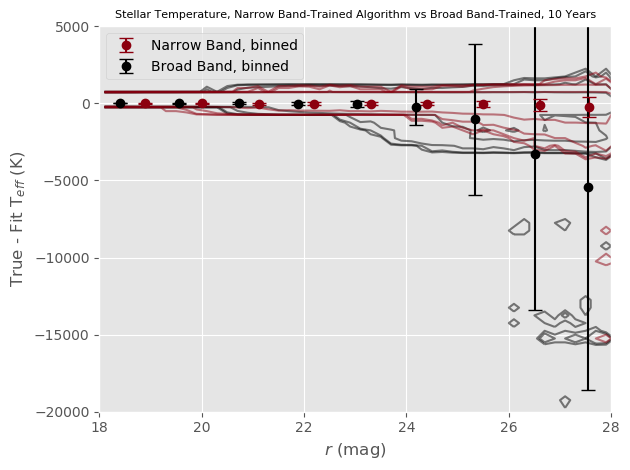

In [32]:
# OK, I don't think I beleive the means on those.  Ah, there was stuff off the plot.

# Need to get rid of scatter and replace with contours.

xedges = np.arange(18,29,.2)
yedges = np.arange(-20000, 7000, 500)

levels = [1, 2, 10, 100, 5000]

H, xedges, yedges = np.histogram2d(truth_catalog['r'], teff_diff, bins=[xedges, yedges])
xcenters = (xedges[:-1] + xedges[1:]) / 2
ycenters = (yedges[:-1] + yedges[1:]) / 2
x,y = np.meshgrid(xcenters, ycenters)
#X, Y = np.meshgrid(xedges, yedges)
plt.contour(x,y,H.T, label='Broad Band Residual Teff', colors='k', levels=levels, alpha=.5)


H, xedges, yedges = np.histogram2d(truth_catalog['r'], nb_teff_diff, bins=[xedges, yedges])
xcenters = (xedges[:-1] + xedges[1:]) / 2
ycenters = (yedges[:-1] + yedges[1:]) / 2
x,y = np.meshgrid(xcenters, ycenters)
#X, Y = np.meshgrid(xedges, yedges)
plt.contour(x,y,H.T, label='Broad Band Residual Teff', colors='xkcd:Crimson', levels=levels, alpha=.5)

narrow_mean, bin_edges, binnum = binned_statistic(truth_catalog['r'], nb_teff_diff, statistic=np.mean, bins=20)
narrow_x, temp1, temp2 = binned_statistic(truth_catalog['r'], truth_catalog['r'], statistic=np.mean, bins=20)
narrow_std, temp1, temp2 = binned_statistic(truth_catalog['r'], nb_teff_diff, statistic=np.std, bins=20)

plt.errorbar(narrow_x, narrow_mean, yerr=narrow_std,fmt='o',
             capsize=5, c='xkcd:Crimson', label='Narrow Band, binned')

broad_mean, bin_edges, binnum = binned_statistic(truth_catalog['r'], teff_diff, statistic=np.mean, bins=19)
broad_x, temp1, temp2 = binned_statistic(truth_catalog['r'], truth_catalog['r'], statistic=np.mean, bins=19)
broad_std, temp1, temp2 = binned_statistic(truth_catalog['r'], teff_diff, statistic=np.std, bins=19)

plt.errorbar(broad_x, broad_mean, yerr=broad_std,fmt='o',
             capsize=5, c='xkcd:black', label='Broad Band, binned')


leg = plt.legend()
for l in leg.legendHandles:
    l.set_alpha(1)
plt.xlim(18,28)
plt.ylim(-20000, 5000)
plt.xlabel('$r$ (mag)')
plt.ylabel('True - Fit T$_{eff}$ (K)')
plt.title('Stellar Temperature, Narrow Band-Trained Algorithm vs Broad Band-Trained, 10 Years', fontsize=8)
plt.tight_layout()
plt.savefig('./current_figs/teff10yrs.pdf')

In [33]:
# Wonder why we don't have really hot stars? <--- As I recall that was as hot as the stellar atm model stars went.
truth_catalog['Teff'].max(), model_atm_mags['Teff'].max()

(7500.0, 50000.0)

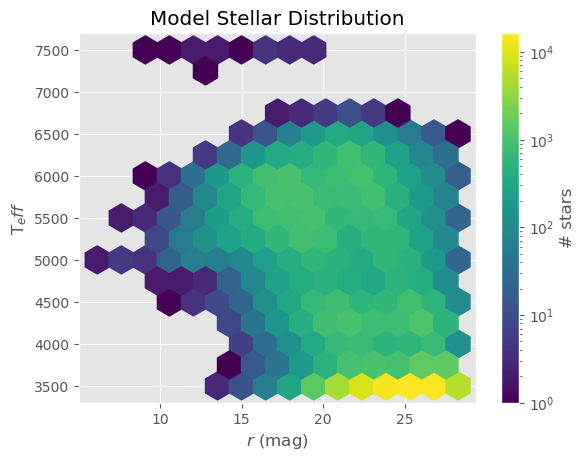

In [34]:
#plt.scatter(truth_catalog['r'], truth_catalog['Teff'])
plt.hexbin(truth_catalog['r'], truth_catalog['Teff'], gridsize=15, norm=mpl.colors.LogNorm(), mincnt=1)
cb = plt.colorbar()
cb.set_label('# stars')
plt.xlabel('$r$ (mag)')
plt.ylabel('T$_eff$')
plt.title('Model Stellar Distribution')
plt.savefig('./current_figs/input_stars.pdf')

Trying out the contour plot for $T_{eff}$ at 1 year:

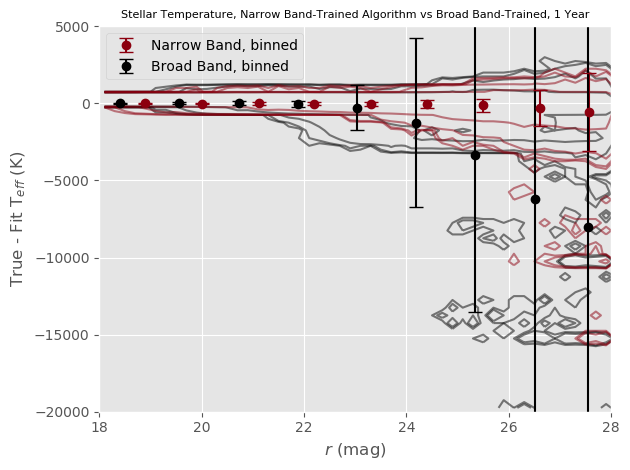

In [35]:
#plt.errorbar(mag_r10yr_teff, temp_r10yr_teff, yerr=std_r10yr_teff, fmt='o', capsize=5, c='xkcd:black', label='Std. Dev., Broad Band')
#plt.scatter(truth_catalog['r'], teff_diff, alpha=0.09, c='xkcd:Barbie Pink', label='Broad Band Residual Teff')
#plt.errorbar(mag_r10yr_nb_teff, temp_r10yr_nb_teff, yerr=std_r10yr_nb_teff, fmt='o', capsize=5, c='xkcd:cream', label='Std. Dev. Narrow Band')
#plt.scatter(truth_catalog['r'], nb_teff_diff, alpha=0.1, c='xkcd:Acid Green', label='Narrow Band Residual Teff')

xedges = np.arange(18,29,.2)
yedges = np.arange(-20000, 7000, 500)

levels = [1, 2, 10, 100, 5000]

H, xedges, yedges = np.histogram2d(truth_catalog['r'], early_teff_diff, bins=[xedges, yedges])
xcenters = (xedges[:-1] + xedges[1:]) / 2
ycenters = (yedges[:-1] + yedges[1:]) / 2
x,y = np.meshgrid(xcenters, ycenters)
#X, Y = np.meshgrid(xedges, yedges)
plt.contour(x,y,H.T, colors='k', levels=levels, alpha=.5)


H, xedges, yedges = np.histogram2d(truth_catalog['r'], early_nb_teff_diff, bins=[xedges, yedges])
xcenters = (xedges[:-1] + xedges[1:]) / 2
ycenters = (yedges[:-1] + yedges[1:]) / 2
x,y = np.meshgrid(xcenters, ycenters)
#X, Y = np.meshgrid(xedges, yedges)
plt.contour(x,y,H.T, colors='xkcd:Crimson', levels=levels, alpha=.5)

narrow_mean, bin_edges, binnum = binned_statistic(truth_catalog['r'], early_nb_teff_diff, statistic=np.mean, bins=20)
narrow_x, temp1, temp2 = binned_statistic(truth_catalog['r'], truth_catalog['r'], statistic=np.mean, bins=20)
narrow_std, temp1, temp2 = binned_statistic(truth_catalog['r'], early_nb_teff_diff, statistic=np.std, bins=20)

plt.errorbar(narrow_x, narrow_mean, yerr=narrow_std,fmt='o',
             capsize=5, c='xkcd:Crimson', label='Narrow Band, binned')

broad_mean, bin_edges, binnum = binned_statistic(truth_catalog['r'], early_teff_diff, statistic=np.mean, bins=19)
broad_x, temp1, temp2 = binned_statistic(truth_catalog['r'], truth_catalog['r'], statistic=np.mean, bins=19)
broad_std, temp1, temp2 = binned_statistic(truth_catalog['r'], early_teff_diff, statistic=np.std, bins=19)

plt.errorbar(broad_x, broad_mean, yerr=broad_std,fmt='o',
             capsize=5, c='xkcd:black', label='Broad Band, binned')

leg = plt.legend()
for l in leg.legendHandles:
    l.set_alpha(1)
plt.xlim(18,28)
plt.ylim(-20000, 5000)
plt.xlabel('$r$ (mag)')
plt.ylabel('True - Fit T$_{eff}$ (K)')
plt.title('Stellar Temperature, Narrow Band-Trained Algorithm vs Broad Band-Trained, 1 Year', fontsize=8)
plt.tight_layout()
plt.savefig('./current_figs/teff1yr.pdf')

### Now for gravity and metallicity, and I'll be honest I still need to work out the ybounds for those.

Gravity:

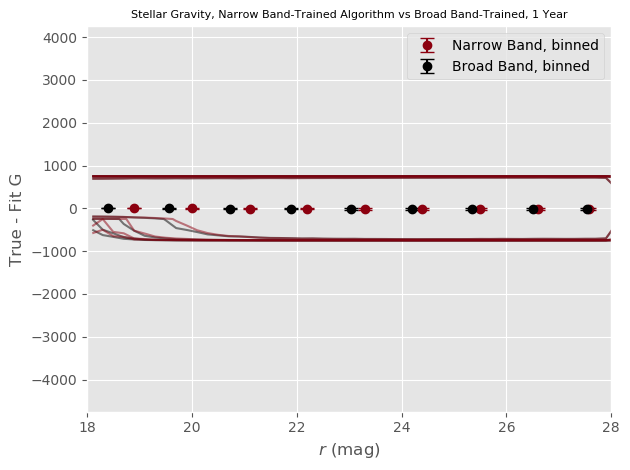

In [36]:
xedges = np.arange(18,29,.2)
yedges = np.arange(-5000, 5000, 500)

levels = [1, 2, 10, 100, 5000]

H, xedges, yedges = np.histogram2d.(truth_catalog['r'], early_G_diff, bins=[xedges, yedges])
xcenters = (xedges[:-1] + xedges[1:]) / 2
ycenters = (yedges[:-1] + yedges[1:]) / 2
x,y = np.meshgrid(xcenters, ycenters)
#X, Y = np.meshgrid(xedges, yedges)
plt.contour(x,y,H.T, colors='k', levels=levels, alpha=.5)


H, xedges, yedges = np.histogram2d(truth_catalog['r'], early_nb_G_diff, bins=[xedges, yedges])
xcenters = (xedges[:-1] + xedges[1:]) / 2
ycenters = (yedges[:-1] + yedges[1:]) / 2
x,y = np.meshgrid(xcenters, ycenters)
#X, Y = np.meshgrid(xedges, yedges)
plt.contour(x,y,H.T, colors='xkcd:Crimson', levels=levels, alpha=.5)

narrow_mean, bin_edges, binnum = binned_statistic(truth_catalog['r'], early_nb_G_diff, statistic=np.mean, bins=20)
narrow_x, temp1, temp2 = binned_statistic(truth_catalog['r'], truth_catalog['r'], statistic=np.mean, bins=20)
narrow_std, temp1, temp2 = binned_statistic(truth_catalog['r'], early_nb_G_diff, statistic=np.std, bins=20)

plt.errorbar(narrow_x, narrow_mean, yerr=narrow_std,fmt='o',
             capsize=5, c='xkcd:Crimson', label='Narrow Band, binned')

broad_mean, bin_edges, binnum = binned_statistic(truth_catalog['r'], early_G_diff, statistic=np.mean, bins=19)
broad_x, temp1, temp2 = binned_statistic(truth_catalog['r'], truth_catalog['r'], statistic=np.mean, bins=19)
broad_std, temp1, temp2 = binned_statistic(truth_catalog['r'], early_G_diff, statistic=np.std, bins=19)

plt.errorbar(broad_x, broad_mean, yerr=broad_std,fmt='o',
             capsize=5, c='xkcd:black', label='Broad Band, binned')

leg = plt.legend()
for l in leg.legendHandles:
    l.set_alpha(1)
plt.xlim(18,28)
#plt.ylim(-20000, 5000)
plt.xlabel('$r$ (mag)')
plt.ylabel('True - Fit G')
plt.title('Stellar Gravity, Narrow Band-Trained Algorithm vs Broad Band-Trained, 1 Year', fontsize=8)
plt.tight_layout()
plt.savefig('./current_figs/gravity1yr.pdf')

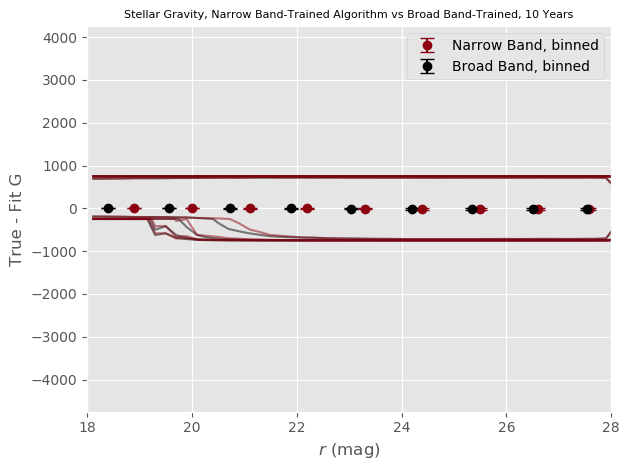

In [37]:
xedges = np.arange(18,29,.2)
yedges = np.arange(-5000, 5000, 500)

levels = [1, 2, 10, 100, 5000]

H, xedges, yedges = np.histogram2d(truth_catalog['r'], G_diff, bins=[xedges, yedges])
xcenters = (xedges[:-1] + xedges[1:]) / 2
ycenters = (yedges[:-1] + yedges[1:]) / 2
x,y = np.meshgrid(xcenters, ycenters)
#X, Y = np.meshgrid(xedges, yedges)
plt.contour(x,y,H.T, colors='k', levels=levels, alpha=.5)


H, xedges, yedges = np.histogram2d(truth_catalog['r'], nb_G_diff, bins=[xedges, yedges])
xcenters = (xedges[:-1] + xedges[1:]) / 2
ycenters = (yedges[:-1] + yedges[1:]) / 2
x,y = np.meshgrid(xcenters, ycenters)
#X, Y = np.meshgrid(xedges, yedges)
plt.contour(x,y,H.T, colors='xkcd:Crimson', levels=levels, alpha=.5)

narrow_mean, bin_edges, binnum = binned_statistic(truth_catalog['r'], nb_G_diff, statistic=np.mean, bins=20)
narrow_x, temp1, temp2 = binned_statistic(truth_catalog['r'], truth_catalog['r'], statistic=np.mean, bins=20)
narrow_std, temp1, temp2 = binned_statistic(truth_catalog['r'], nb_G_diff, statistic=np.std, bins=20)

plt.errorbar(narrow_x, narrow_mean, yerr=narrow_std,fmt='o',
             capsize=5, c='xkcd:Crimson', label='Narrow Band, binned')

broad_mean, bin_edges, binnum = binned_statistic(truth_catalog['r'], G_diff, statistic=np.mean, bins=19)
broad_x, temp1, temp2 = binned_statistic(truth_catalog['r'], truth_catalog['r'], statistic=np.mean, bins=19)
broad_std, temp1, temp2 = binned_statistic(truth_catalog['r'], G_diff, statistic=np.std, bins=19)

plt.errorbar(broad_x, broad_mean, yerr=broad_std,fmt='o',
             capsize=5, c='xkcd:black', label='Broad Band, binned')

leg = plt.legend()
for l in leg.legendHandles:
    l.set_alpha(1)
plt.xlim(18,28)
#plt.ylim(-20000, 5000)
plt.xlabel('$r$ (mag)')
plt.ylabel('True - Fit G')
plt.title('Stellar Gravity, Narrow Band-Trained Algorithm vs Broad Band-Trained, 10 Years', fontsize=8)
plt.tight_layout()
plt.savefig('./current_figs/gravity10yrs.pdf')

Metallicity:

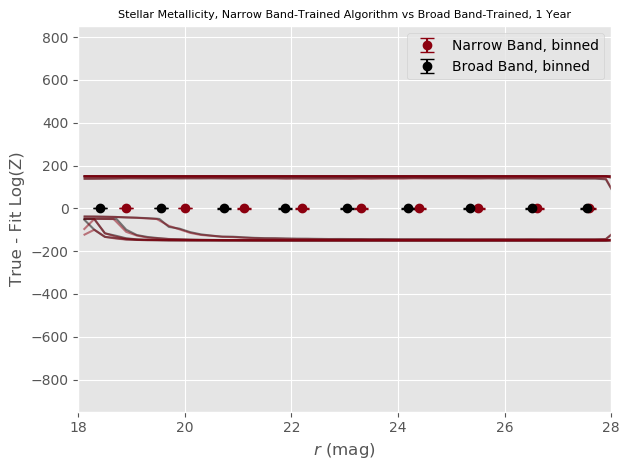

In [38]:
# 1 year

xedges = np.arange(18,29,.2)
yedges = np.arange(-1000, 1000, 100)

levels = [1, 2, 10, 100, 5000]

H, xedges, yedges = np.histogram2d(truth_catalog['r'], early_Z_diff, bins=[xedges, yedges])
xcenters = (xedges[:-1] + xedges[1:]) / 2
ycenters = (yedges[:-1] + yedges[1:]) / 2
x,y = np.meshgrid(xcenters, ycenters)
#X, Y = np.meshgrid(xedges, yedges)
plt.contour(x,y,H.T, colors='k', levels=levels, alpha=.5)

H, xedges, yedges = np.histogram2d(truth_catalog['r'], early_nb_Z_diff, bins=[xedges, yedges])
xcenters = (xedges[:-1] + xedges[1:]) / 2
ycenters = (yedges[:-1] + yedges[1:]) / 2
x,y = np.meshgrid(xcenters, ycenters)
#X, Y = np.meshgrid(xedges, yedges)
plt.contour(x,y,H.T, colors='xkcd:Crimson', levels=levels, alpha=.5)

narrow_mean, bin_edges, binnum = binned_statistic(truth_catalog['r'], early_nb_Z_diff, statistic=np.mean, bins=20)
narrow_x, temp1, temp2 = binned_statistic(truth_catalog['r'], truth_catalog['r'], statistic=np.mean, bins=20)
narrow_std, temp1, temp2 = binned_statistic(truth_catalog['r'], early_nb_Z_diff, statistic=np.std, bins=20)

plt.errorbar(narrow_x, narrow_mean, yerr=narrow_std,fmt='o',
             capsize=5, c='xkcd:Crimson', label='Narrow Band, binned')

broad_mean, bin_edges, binnum = binned_statistic(truth_catalog['r'], early_Z_diff, statistic=np.mean, bins=19)
broad_x, temp1, temp2 = binned_statistic(truth_catalog['r'], truth_catalog['r'], statistic=np.mean, bins=19)
broad_std, temp1, temp2 = binned_statistic(truth_catalog['r'], early_Z_diff, statistic=np.std, bins=19)

plt.errorbar(broad_x, broad_mean, yerr=broad_std,fmt='o',
             capsize=5, c='xkcd:black', label='Broad Band, binned')

leg = plt.legend()
for l in leg.legendHandles:
    l.set_alpha(1)
plt.xlim(18,28)
#plt.ylim(-20000, 5000)
plt.xlabel('$r$ (mag)')
plt.ylabel('True - Fit Log(Z)')
plt.title('Stellar Metallicity, Narrow Band-Trained Algorithm vs Broad Band-Trained, 1 Year', fontsize=8)
plt.tight_layout()
plt.savefig('./current_figs/log_Z1yr.pdf')

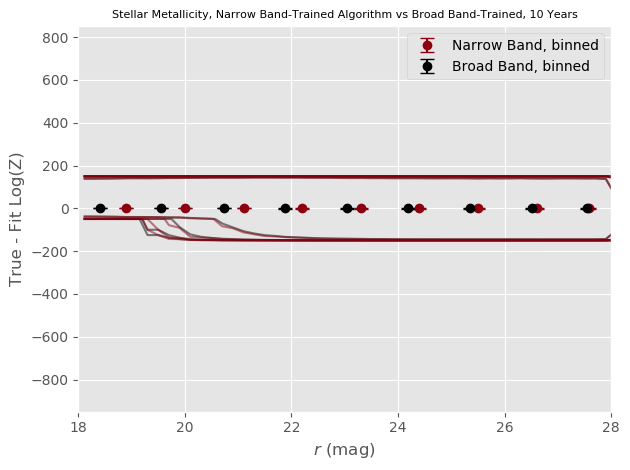

In [39]:
# 10 years

xedges = np.arange(18,29,.2)
yedges = np.arange(-1000, 1000, 100)

levels = [1, 2, 10, 100, 5000]

H, xedges, yedges = np.histogram2d(truth_catalog['r'], Z_diff, bins=[xedges, yedges])
xcenters = (xedges[:-1] + xedges[1:]) / 2
ycenters = (yedges[:-1] + yedges[1:]) / 2
x,y = np.meshgrid(xcenters, ycenters)
#X, Y = np.meshgrid(xedges, yedges)
plt.contour(x,y,H.T, colors='k', levels=levels, alpha=.5)

H, xedges, yedges = np.histogram2d(truth_catalog['r'], nb_Z_diff, bins=[xedges, yedges])
xcenters = (xedges[:-1] + xedges[1:]) / 2
ycenters = (yedges[:-1] + yedges[1:]) / 2
x,y = np.meshgrid(xcenters, ycenters)
#X, Y = np.meshgrid(xedges, yedges)
plt.contour(x,y,H.T, colors='xkcd:Crimson', levels=levels, alpha=.5)

narrow_mean, bin_edges, binnum = binned_statistic(truth_catalog['r'], nb_Z_diff, statistic=np.mean, bins=20)
narrow_x, temp1, temp2 = binned_statistic(truth_catalog['r'], truth_catalog['r'], statistic=np.mean, bins=20)
narrow_std, temp1, temp2 = binned_statistic(truth_catalog['r'], nb_Z_diff, statistic=np.std, bins=20)

plt.errorbar(narrow_x, narrow_mean, yerr=narrow_std,fmt='o',
             capsize=5, c='xkcd:Crimson', label='Narrow Band, binned')

broad_mean, bin_edges, binnum = binned_statistic(truth_catalog['r'], Z_diff, statistic=np.mean, bins=19)
broad_x, temp1, temp2 = binned_statistic(truth_catalog['r'], truth_catalog['r'], statistic=np.mean, bins=19)
broad_std, temp1, temp2 = binned_statistic(truth_catalog['r'], Z_diff, statistic=np.std, bins=19)

plt.errorbar(broad_x, broad_mean, yerr=broad_std,fmt='o',
             capsize=5, c='xkcd:black', label='Broad Band, binned')

leg = plt.legend()
for l in leg.legendHandles:
    l.set_alpha(1)
plt.xlim(18,28)
#plt.ylim(-20000, 5000)
plt.xlabel('$r$ (mag)')
plt.ylabel('True - Fit Log(Z)')
plt.title('Stellar Metallicity, Narrow Band-Trained Algorithm vs Broad Band-Trained, 10 Years', fontsize=8)
plt.tight_layout()
plt.savefig('./current_figs/log_Z10yrs.pdf')